# AnTeDe Word Embeddings Lab - Part C

## Session goal
The goal of this session is to carry out word sense disambiguation using word embeddings.

The following cell contains our preprocessing code that you may recall from previous activities.

In [1]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

class LemmaTokenizer(object):
    
     def __init__(self):
         self.wnl = WordNetLemmatizer()
            
        
     @staticmethod   
     def clean(words):
        from nltk.corpus import stopwords
        from string import punctuation
        to_be_removed = set(stopwords.words('english')+list(punctuation))
        return [word.lower() for word in words if word not in to_be_removed]
        
     def __call__(self, doc):
         return [self.wnl.lemmatize(t)\
                 for t in self.clean(word_tokenize(doc))\
                 if (t.isalnum())]
        
preprocessor=LemmaTokenizer()



The following cell contains out WordNet-specific code to extract the typical context of a word sense based on its WordNet gloss. It can be **extended** to also us the WordNet examples. Note (by toggling **showExample** from **False** to **True**) that the WordNet context is provided as a list of lists of tokens.

In [2]:
from nltk.corpus import wordnet as wn

showExample=True


def get_gloss(target_word, number):
    synsets=wn.synsets(target_word, "n")
    for i, synset in enumerate(synsets):
        if (number == (i+1)):
         return synset.definition()

def get_context(synset, extended=False):
    if extended:
        examples = ' '.join(synset.examples())
        return synset.definition()+" "+examples
    else:
        return synset.definition()

def get_wordnet_contexts(word):
    from nltk.corpus import wordnet as wn
    
    synsets=wn.synsets(word, "n")
    wordnet_glosses={}
    for i, synset in enumerate(synsets):
        wordnet_glosses[synset.name()]=preprocessor(get_context(synset, extended=True))
    return list(wordnet_glosses.values())

if showExample:
    print (get_wordnet_contexts('interest'))
       

[['sense', 'concern', 'curiosity', 'someone', 'something', 'interest', 'music'], ['reason', 'wanting', 'something', 'done', 'sake', 'died', 'sake', 'country', 'interest', 'safety', 'common', 'interest'], ['power', 'attracting', 'holding', 'one', 'attention', 'unusual', 'exciting', 'etc', 'said', 'nothing', 'great', 'interest', 'primary', 'color', 'add', 'interest', 'room'], ['fixed', 'charge', 'borrowing', 'money', 'usually', 'percentage', 'amount', 'borrowed', 'much', 'interest', 'pay', 'mortgage'], ['law', 'right', 'legal', 'share', 'something', 'financial', 'involvement', 'something', 'interest', 'world', 'stake', 'company', 'future'], ['usually', 'plural', 'social', 'group', 'whose', 'member', 'control', 'field', 'activity', 'common', 'aim', 'iron', 'interest', 'stepped', 'production'], ['diversion', 'occupies', 'one', 'time', 'thought', 'usually', 'pleasantly', 'sailing', 'favorite', 'pastime', 'main', 'pastime', 'gambling', 'count', 'reading', 'among', 'interest', 'criticized', '

Now we load the GloVe embeddings. The following cell is configured to use 50-dimensional embeddings, but you're welcome to change the dimensionality to the other available options: 100, 200, or 300. 

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import os
dimensions=50
filepath_1='./glove.6B/glove.6B.'+str(dimensions)+'d.'
filepath_2=filepath_1+'word2vec.'
glove_file = datapath(os.path.abspath(filepath_1+'txt'))
word2vec_glove_file = get_tmpfile(os.path.join(os.getcwd(), filepath_2+'.txt'))
_ = glove2word2vec(glove_file, word2vec_glove_file)

model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

The function **get_vectors** in the following cell has two input arguments:
* the model we just prepared
* a list called **words**

As you can see by analyzing the source code:
* The first element in the list **words** is the target word whose sense you wish to disambiguate (in the example below, *bank*)
* The other elements of the list **words** must be lists of context words. Earlier in this notebook, you were provided with a function called **get_wordnet_contexts** that extracts the WordNet context as a list of lists. In the example below the function **get_vectors**, we extract the lists from inside the list of lists.
* The function **get_vectors** returns the embedding vectors of the target word and its various senses as available in WordNet. 



In [4]:
def get_vectors (model, words):
    
    import numpy as np
    word_vector_list=[]
    
    
    for i, w in enumerate(words):
        
        if type(w)==list:
            v_ww = np.zeros(dimensions, dtype='float32')
            
            for ww in w:
                
            
                try:
                    v_ww=np.add(v_ww, model[ww])
                except:
                    pass
            v_ww=np.divide(v_ww, len(w))       
            word_vector_list.append(v_ww)
            
            if i==0:
                words[i]='sentence'
            else:
                words[i]='context_'+str(i)
            
        
        else:
            word_vector_list.append(model[w]) 
        
    return np.array(word_vector_list)

# Usage example
target_word = 'bank'
words = [target_word, *get_wordnet_contexts(target_word)]
word_vectors = get_vectors (model, words)


In the next cell, we show the 2-dimensional representation of the embedding vector for **bank** and the embedding vectors that capture the context of the glosses of the various senses of **bank** in WordNet.

<IPython.core.display.Javascript object>


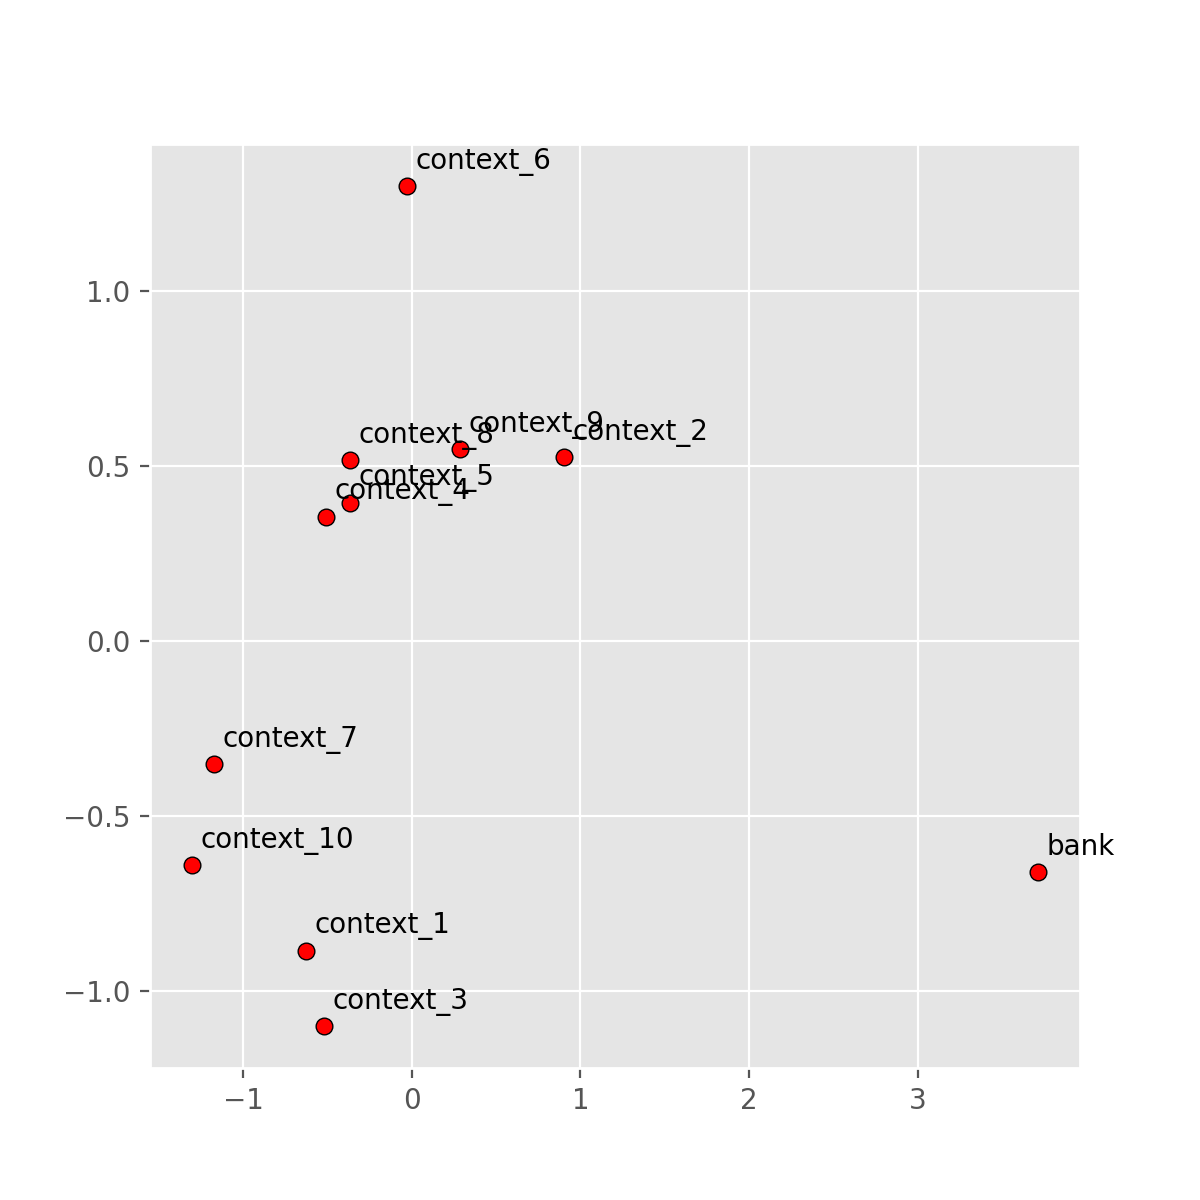

In [5]:
target_word = 'bank'
words = [target_word, *get_wordnet_contexts(target_word)]


def display_pca_scatterplot(model, words):
    
    word_vectors = get_vectors (model, words)
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
    plt.savefig("context_embedding.png")   
        
display_pca_scatterplot(model, words)        

Here are the WordNet definitions of the 10 contexts of the word **bank**.

In [6]:
for sense in range (1, len(word_vectors)):
    print ('context_'+str(sense)+': '+get_gloss(target_word, sense))

context_1: sloping land (especially the slope beside a body of water)
context_2: a financial institution that accepts deposits and channels the money into lending activities
context_3: a long ridge or pile
context_4: an arrangement of similar objects in a row or in tiers
context_5: a supply or stock held in reserve for future use (especially in emergencies)
context_6: the funds held by a gambling house or the dealer in some gambling games
context_7: a slope in the turn of a road or track; the outside is higher than the inside in order to reduce the effects of centrifugal force
context_8: a container (usually with a slot in the top) for keeping money at home
context_9: a building in which the business of banking transacted
context_10: a flight maneuver; aircraft tips laterally about its longitudinal axis (especially in turning)


We can represent a sentence by averaging out the embeddings of its content words. If you look back at **get_vectors**, you'll realize that the first element of the input **words** can also be a sentence containg the word whose sense needs disambiguating. We demonstrate that in the following cell.

In [7]:
import numpy as np

def cosine_sim (vA, vB):
    return np.dot(vA, vB) / (np.sqrt(np.dot(vA,vA)) * np.sqrt(np.dot(vB,vB)))

def wsd (target_word, target_sentence, show_fig=False):

    words = [preprocessor(target_sentence), *get_wordnet_contexts(target_word)]

    if show_fig:
        display_pca_scatterplot(model, words) 
    
    cos_sim=[]
    words = [preprocessor(target_sentence), *get_wordnet_contexts(target_word)]
    word_vectors = get_vectors (model, words)
    reference = word_vectors[0]
    highest_cs = 0

    for i in range(1, len(word_vectors)):
            cs=cosine_sim(reference, word_vectors[i])
            print ('Cosine similarity between target and context_'+str(i)+'='+str(cs))
            if cs>highest_cs:
                highest_cs=cs
                chosen_context = i

    print ('Chosen context: ', get_gloss(target_word, chosen_context))    
    

In [8]:
target_word = 'bank'
target_sentence = 'Our boat sank in the river on the way to the bank.'

wsd(target_word, target_sentence)

Cosine similarity between target and context_1=0.9026557
Cosine similarity between target and context_2=0.7560338
Cosine similarity between target and context_3=0.8684022
Cosine similarity between target and context_4=0.7443628
Cosine similarity between target and context_5=0.78223187
Cosine similarity between target and context_6=0.69451344
Cosine similarity between target and context_7=0.81078976
Cosine similarity between target and context_8=0.7723302
Cosine similarity between target and context_9=0.7299862
Cosine similarity between target and context_10=0.8317708
Chosen context:  sloping land (especially the slope beside a body of water)


In [9]:
target_word = 'bank'
target_sentence = 'My money will stay in the bank.'

wsd(target_word, target_sentence)

Cosine similarity between target and context_1=0.79228723
Cosine similarity between target and context_2=0.8988707
Cosine similarity between target and context_3=0.78637207
Cosine similarity between target and context_4=0.757392
Cosine similarity between target and context_5=0.8258195
Cosine similarity between target and context_6=0.84157455
Cosine similarity between target and context_7=0.7725524
Cosine similarity between target and context_8=0.8689463
Cosine similarity between target and context_9=0.758621
Cosine similarity between target and context_10=0.6630927
Chosen context:  a financial institution that accepts deposits and channels the money into lending activities


Let's look at the word *interest*. What happens in the following cells?

In [10]:
target_word = 'interest'
words = [target_word, *get_wordnet_contexts(target_word)]
word_vectors = get_vectors (model, words)
for sense in range (1, len(word_vectors)):
    print ('context_'+str(sense)+': '+get_gloss(target_word, sense))

context_1: a sense of concern with and curiosity about someone or something
context_2: a reason for wanting something done
context_3: the power of attracting or holding one's attention (because it is unusual or exciting etc.)
context_4: a fixed charge for borrowing money; usually a percentage of the amount borrowed
context_5: (law) a right or legal share of something; a financial involvement with something
context_6: (usually plural) a social group whose members control some field of activity and who have common aims
context_7: a diversion that occupies one's time and thoughts (usually pleasantly)


In [11]:
target_word = 'interest'
target_sentence = 'My mortgage has a low interest rate.'

wsd(target_word, target_sentence)

Cosine similarity between target and context_1=0.7733712
Cosine similarity between target and context_2=0.80510926
Cosine similarity between target and context_3=0.81369233
Cosine similarity between target and context_4=0.93633074
Cosine similarity between target and context_5=0.8200247
Cosine similarity between target and context_6=0.767551
Cosine similarity between target and context_7=0.74613494
Chosen context:  a fixed charge for borrowing money; usually a percentage of the amount borrowed


In [12]:
target_word = 'interest'
target_sentence = 'Mountains are her main interest.'

wsd(target_word, target_sentence)

Cosine similarity between target and context_1=0.6909903
Cosine similarity between target and context_2=0.7449884
Cosine similarity between target and context_3=0.823687
Cosine similarity between target and context_4=0.7143122
Cosine similarity between target and context_5=0.7616841
Cosine similarity between target and context_6=0.84889907
Cosine similarity between target and context_7=0.8220569
Chosen context:  (usually plural) a social group whose members control some field of activity and who have common aims


In [13]:
target_word = 'interest'
target_sentence = 'Mountains are her main interest and she spends most of her free time hiking.'

wsd(target_word, target_sentence)

Cosine similarity between target and context_1=0.7430218
Cosine similarity between target and context_2=0.8119385
Cosine similarity between target and context_3=0.85976815
Cosine similarity between target and context_4=0.77137804
Cosine similarity between target and context_5=0.79076934
Cosine similarity between target and context_6=0.82800883
Cosine similarity between target and context_7=0.8978887
Chosen context:  a diversion that occupies one's time and thoughts (usually pleasantly)
